<a href="https://colab.research.google.com/github/ankojubhanuprakash/WorkSpace/blob/main/weightpred_pytoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Default title text
import scipy.io
mat = scipy.io.loadmat('metadata.mat')

In [14]:
import pandas as pd
import numpy as np

In [62]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
#from torch._C import T
from torch.nn.modules.conv import ConvTranspose2d
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [18]:
for i in list(mat.keys())[3:]:
  print(i,pd.Series(np.array(mat[i]).flatten()).shape)

np.array(mat['pressure']).shape

recordings (27,)
recordingId (11682,)
objects (27,)
objectId (11682,)
pressure (11962368,)
frame (11682,)
ts (11682,)
graspIndex (11682,)
graspValid (11682,)
batchId (11682,)
batches (1,)
weights (27,)


(11682, 32, 32)

In [43]:
pd.DataFrame([np.array(mat['objects']).T.flatten(),np.array(mat['weights']).T.flatten()]).T

,0,1
0,[empty_hand],0
1,[allen_key_set],350
2,[ball],55
3,[battery],135
4,[board_eraser],41
5,[bracket],53
6,[brain],23
7,[cat],679
8,[chain],142
9,[clip],24


In [84]:
torch.Tensor(np.array(mat['objectId'],dtype=np.int32).flatten()).shape

torch.Size([11682])

In [52]:
presure_data = torch.Tensor(np.array(mat['pressure']))
pressure_data = presure_data.view(11682,-1,32,32)

In [247]:
class Pressure_Weight_data(Dataset):
  def __init__(self,pressure,weights,objectid):
    self.pressure_data = torch.Tensor(pressure)
    self.pressure_data = self.pressure_data.view(len(self.pressure_data),-1,32,32)
    self.weights = torch.Tensor(weights)
    self.objectid = objectid
  def __len__(self):
    return len(self.pressure_data )
  def __getitem__(self,index):
    #mean,std = self.pressure_data[index].mean(),self.pressure_data[index].std()
    return(self.pressure_data[index].normal_(0,4 ),self.weights[self.objectid[index]])    



In [248]:
PoplationData =  Pressure_Weight_data(np.array(mat['pressure']),np.array(mat['weights'],dtype=np.int32),np.array(mat['objectId'],dtype=np.int32).flatten())


In [245]:
a = PoplationData[0][0].mean()
b = PoplationData[0][0].std()

In [249]:
PoplationData[0][0]

tensor([[[ 2.0439,  1.3678,  5.0173,  ..., -2.2368, -2.6360, -2.9025],
         [ 4.7536,  1.1726, -2.3575,  ...,  3.0818, -0.2997,  0.9877],
         [ 5.5732, -1.8075, -0.0758,  ...,  4.6540, -8.9022, -6.8763],
         ...,
         [ 7.8873,  4.0661, -5.1776,  ...,  0.1340, -4.3859,  1.4466],
         [ 8.0980,  2.0807, -2.7481,  ...,  0.9079,  5.3505,  3.7288],
         [ 2.3662,  5.7921,  4.9514,  ..., -1.8332,  3.8592,  6.1236]]])

In [154]:
torch.Tensor(np.array(mat['weights'],dtype=np.int32))

tensor([[  0.],
        [350.],
        [ 55.],
        [135.],
        [ 41.],
        [ 53.],
        [ 23.],
        [679.],
        [142.],
        [ 24.],
        [ 14.],
        [ 13.],
        [382.],
        [127.],
        [146.],
        [320.],
        [509.],
        [396.],
        [ 11.],
        [ 23.],
        [ 83.],
        [  8.],
        [  4.],
        [ 29.],
        [162.],
        [ 30.],
        [188.]])

In [250]:
#train test split
train_set,hold_set,test_set = torch.utils.data.random_split(PoplationData,[8177,2000,1505])

In [282]:
train_loader = DataLoader(train_set,batch_size=100,shuffle=True)
Valid_loader = DataLoader(hold_set,batch_size=50,shuffle=True)


In [252]:
cc = nn.Conv2d(1, 32, kernel_size=8, stride=4)

In [253]:
kk=torch.zeros([1,32,32])

In [254]:
model._get_conv_out([1,32,32])

160

In [260]:
#
# Building Our Mode
class Network(nn.Module):
    # Declaring the Architecture
    def __init__(self):
        super(Network,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 10, kernel_size=3, stride=1),
            nn.ReLU()   
             )
        conv_out_size = self._get_conv_out([1,32,32])
        self.fc = nn.Sequential(
                nn.Linear(conv_out_size, 10),
                nn.ReLU(),
                nn.Linear(10, 5) ,
                nn.ReLU(),
                #nn.Linear(100, 10),
                #nn.ReLU(),
                nn.Linear(5,1 )
                                  )
    def _get_conv_out(self, shape):
      o = self.conv(torch.zeros(1, *shape))
      return int(np.prod(o.size()))


    # Forward Pass
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
        


In [299]:
model = Network()
train_arr,valid_arr = [],[]



In [300]:
 # Declaring Criterion and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
 
# Training with Validation
epochs = 40
min_valid_loss = np.inf
 
for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        #print(labels,target)
        #xx=input()

        # Find the Loss
        loss = criterion(target,labels)

        #print(loss,labels,target)
        #xx=input()
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
     
    valid_loss = 0.0
    #model.eval()     # Optional when not using Model Specific layer
    for data, labels in Valid_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate Loss
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t\t Training Loss: {\
    train_loss / len(train_loader)} \t\t Validation Loss: {\
    valid_loss / len(Valid_loader)}')
    train_arr.append(train_loss / len(train_loader)),valid_arr.append(valid_loss / len(Valid_loader))
    
     
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
         
        # Saving State Dict
        #torch.save(model.state_dict(), 'saved_model.pth')



Epoch 1 		 Training Loss: 3627438604380.6226 		 Validation Loss: 201406.251953125
Validation Loss Decreased(inf--->8056250.078125) 	 Saving The Model
Epoch 2 		 Training Loss: 41394.86335270579 		 Validation Loss: 32186.65524902344
Validation Loss Decreased(8056250.078125--->1287466.209961) 	 Saving The Model
Epoch 3 		 Training Loss: 30512.084532202745 		 Validation Loss: 32208.05625
Epoch 4 		 Training Loss: 30551.32402820122 		 Validation Loss: 32184.815771484376
Validation Loss Decreased(1287466.209961--->1287392.630859) 	 Saving The Model
Epoch 5 		 Training Loss: 30529.22549066311 		 Validation Loss: 32187.29990234375
Epoch 6 		 Training Loss: 30532.972894435974 		 Validation Loss: 32205.053588867188
Epoch 7 		 Training Loss: 30529.304854230184 		 Validation Loss: 32195.905859375
Epoch 8 		 Training Loss: 30541.382729134908 		 Validation Loss: 32185.118017578126
Epoch 9 		 Training Loss: 30520.44774199695 		 Validation Loss: 32189.29248046875
Epoch 10 		 Training Loss: 30524.2222

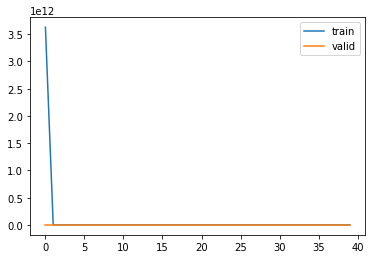

In [304]:
plt.plot(train_arr,label='train')
plt.plot(valid_arr,label='valid')
plt.legend()
plt.show()

In [111]:
len(PoplationData)

11682

In [112]:
11682-8177

3505

In [100]:
mat['objectId'][0]

array([8], dtype=uint8)

In [101]:
np.array(mat['weights'])[8]

array([142], dtype=uint16)